Epoch 1/500 | Train Loss: 0.7658272981643677 | Validation Loss: 0.6270900666713715
Epoch 2/500 | Train Loss: 0.6225050091743469 | Validation Loss: 0.5910695493221283
Epoch 3/500 | Train Loss: 0.5403043131033579 | Validation Loss: 0.552761971950531
Epoch 4/500 | Train Loss: 0.5576212803522745 | Validation Loss: 0.5410899519920349
Epoch 5/500 | Train Loss: 0.4643614689509074 | Validation Loss: 0.526577353477478
Epoch 6/500 | Train Loss: 0.4414605299631755 | Validation Loss: 0.5219907313585281
Epoch 7/500 | Train Loss: 0.43559707204500836 | Validation Loss: 0.5201547145843506
Epoch 8/500 | Train Loss: 0.3996007442474365 | Validation Loss: 0.5155728459358215
Epoch 9/500 | Train Loss: 0.3871750036875407 | Validation Loss: 0.5087214112281799
Epoch 10/500 | Train Loss: 0.3418831179539363 | Validation Loss: 0.5050458014011383
Epoch 11/500 | Train Loss: 0.32371509075164795 | Validation Loss: 0.49771784245967865
Epoch 12/500 | Train Loss: 0.3207058012485504 | Validation Loss: 0.49199555814266205

/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3386285509.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3386285509.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3386285509.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

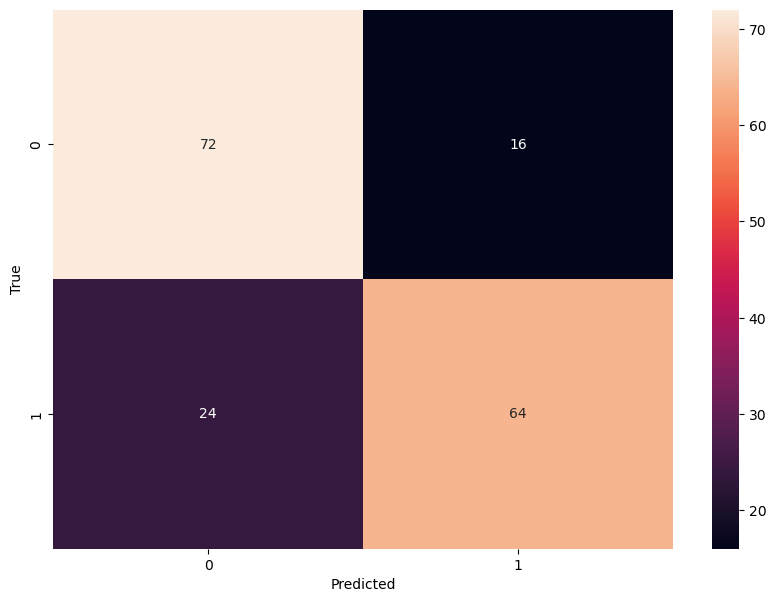

Incorrect Predictions:
Text: Last night created an account on Capital Ones XXXX XXXX XXXX upon creating the account I found a number of errors including a {$580.00} fee from original lender, XXXX etc location, XXXX XXXX, XXXX. I filed a complaint last night this afternoon I tried to log back into the XXXX XXXX XXXX, and it would not allow me and kept giving error. My account was compromised. Also, there was false addresses associated with my credit account as well. : Address : XXXX XXXX XXXX XXXX XXXX XXXX XXXX. Its showing up on my credit report.. unfortunately, Ive never lived at this location or have I ever been associated with this location Im thinking maybe the person who compromised my account may be associated with that location. These errors above or the reason for this complaint, Predicted: 1, Actual: 0
Text: I had originally applied for a Capital One card, which I never received the first two cards that was doing the height of the Covid situation everywhere, as well like I sp

In [20]:
### Use STSB model and logistic regression in PyTorch with manual hyperparameter tuning (2 classes)
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

def extract_features(narratives):
    features = []
    domain_terms = domain_terms = ['credit', 'consumer', 'information', 'account', 'report', 'company',
    'services', 'debt', 'reporting', 'card', 'law', 'refund', 'financial',
    'act', 'loan', 'score', 'service', 'money', 'repair', 'received',
    'complaint', 'action', 'unauthorized', 'paid', 'payments', 'fair',
    'accounts', 'business', 'payment', 'call', 'right', 'section', 'fee',
    'rights', 'provided', 'practices', 'full', 'email', 'USC', 'violation',
    'identity', 'months', 'experian']
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        combined_features = torch.cat((self.encodings[idx], torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item = {'features': combined_features, 'labels': torch.tensor(self.labels[idx])}
        return item

    def __len__(self):
        return len(self.labels)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 2)  # Assuming 2 output classes for binary classification

    def forward(self, x):
        out = self.linear(x)
        return out

# Load and preprocess the dataset
file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Manually extract features
manual_features = extract_features(df['Consumer complaint narrative'])

# Define the ratios for splitting the dataset
train_ratio = 0.10
validation_ratio = 0.10
test_ratio = 0.80

# Split the dataset and manual features
train_data, temp_data = train_test_split(df, train_size=train_ratio, stratify=df['Label'])
train_manual_features, temp_manual_features = train_test_split(manual_features, train_size=train_ratio, stratify=df['Label'])
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])
val_manual_features, test_manual_features = train_test_split(temp_manual_features, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features for each set
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Consumer complaint narrative'])
val_tfidf = tfidf_vectorizer.transform(val_data['Consumer complaint narrative'])
test_tfidf = tfidf_vectorizer.transform(test_data['Consumer complaint narrative'])

# Extract texts for each set
train_texts, train_labels = train_data['Consumer complaint narrative'].tolist(), train_data['Label'].tolist()
val_texts, val_labels = val_data['Consumer complaint narrative'].tolist(), val_data['Label'].tolist()
test_texts, test_labels = test_data['Consumer complaint narrative'].tolist(), test_data['Label'].tolist()

# Initialize the tokenizer and model for 'stsb-bert-base'
tokenizer = BertTokenizer.from_pretrained('sentence-transformers/stsb-bert-base')
bert_model = BertModel.from_pretrained('sentence-transformers/stsb-bert-base')

def encode_texts(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = bert_model(**encoded_input)
    return model_output.pooler_output

# Encode the data
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

# Create datasets with Sentence Transformer features, manual, and TF-IDF features
train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
test_dataset = ComplaintsDataset(torch.tensor(test_encodings), test_manual_features, test_tfidf, test_labels)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the logistic regression model with the updated input dimension
input_dim = train_encodings.shape[1] + len(train_manual_features[0]) + 500
logistic_regression_model = LogisticRegressionModel(input_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic_regression_model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop with early stopping for logistic regression
num_epochs = 500
patience = 10
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    logistic_regression_model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_features = batch['features']
        batch_labels = batch['labels']

        optimizer.zero_grad()

        logits = logistic_regression_model(batch_features)
        loss = criterion(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    logistic_regression_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            val_logits = logistic_regression_model(val_features)
            val_loss = criterion(val_logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

# Evaluation for 2-class classification using logistic regression
logistic_regression_model.eval()
test_predictions = []
test_references = []
incorrect_pred_texts = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = logistic_regression_model(batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

        # Identify incorrect predictions and store the corresponding text
        for j, (pred, label) in enumerate(zip(predictions, batch_labels.tolist())):
            if pred != label:
                incorrect_pred_texts.append((test_texts[i * test_loader.batch_size + j], pred, label))

# Calculate test set metrics for 2-class classification using logistic regression
accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 2 classes (Logistic Regression): {accuracy}')
print(f'Test F1 Score for 2 classes (Logistic Regression): {f1}')

# Confusion Matrix for 2-class classification
conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print incorrect predictions
print("Incorrect Predictions:")
for text, pred, label in incorrect_pred_texts:
    print(f"Text: {text}, Predicted: {pred}, Actual: {label}")

/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2050958847.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2050958847.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2050958847.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

Epoch 1/500 | Train Loss: 1.8115230798721313 | Validation Loss: 1.6650439103444417
Epoch 2/500 | Train Loss: 1.6363829572995503 | Validation Loss: 1.6447148720423381
Epoch 3/500 | Train Loss: 1.6049580176671345 | Validation Loss: 1.627290964126587
Epoch 4/500 | Train Loss: 1.5965608358383179 | Validation Loss: 1.6123082637786865
Epoch 5/500 | Train Loss: 1.5660502115885417 | Validation Loss: 1.6002235412597656
Epoch 6/500 | Train Loss: 1.5446415543556213 | Validation Loss: 1.5888620615005493
Epoch 7/500 | Train Loss: 1.5484451452891033 | Validation Loss: 1.5785201787948608
Epoch 8/500 | Train Loss: 1.526984413464864 | Validation Loss: 1.5691828330357869
Epoch 9/500 | Train Loss: 1.640278955300649 | Validation Loss: 1.5608833233515422
Epoch 10/500 | Train Loss: 1.502211570739746 | Validation Loss: 1.5525952577590942
Epoch 11/500 | Train Loss: 1.5038917859395344 | Validation Loss: 1.5463375250498455
Epoch 12/500 | Train Loss: 1.49418310324351 | Validation Loss: 1.5406780242919922
Epoch 1

Epoch 105/500 | Train Loss: 1.1237224539120991 | Validation Loss: 1.3335367838541667
Epoch 106/500 | Train Loss: 1.0675935645898182 | Validation Loss: 1.3315051396687825
Epoch 107/500 | Train Loss: 1.0819772879282634 | Validation Loss: 1.3297720352808635
Epoch 108/500 | Train Loss: 1.0740842322508495 | Validation Loss: 1.3279630740483601
Epoch 109/500 | Train Loss: 1.0941560665766399 | Validation Loss: 1.326571782430013
Epoch 110/500 | Train Loss: 1.0663495163122814 | Validation Loss: 1.3252589305241902
Epoch 111/500 | Train Loss: 1.0877726078033447 | Validation Loss: 1.3242216110229492
Epoch 112/500 | Train Loss: 1.0590841074784596 | Validation Loss: 1.3225117127100627
Epoch 113/500 | Train Loss: 1.058325747648875 | Validation Loss: 1.320849617322286
Epoch 114/500 | Train Loss: 1.0133612751960754 | Validation Loss: 1.3197240034739177
Epoch 115/500 | Train Loss: 1.0574303368727367 | Validation Loss: 1.3182998498280842
Epoch 116/500 | Train Loss: 1.0439474085966747 | Validation Loss: 1.

Epoch 208/500 | Train Loss: 0.8397919336954752 | Validation Loss: 1.2246441841125488
Epoch 209/500 | Train Loss: 0.8451628883679708 | Validation Loss: 1.2237850824991863
Epoch 210/500 | Train Loss: 0.8211779594421387 | Validation Loss: 1.2241838375727336
Epoch 211/500 | Train Loss: 0.8202042082945505 | Validation Loss: 1.2237618764241536
Epoch 212/500 | Train Loss: 0.8423967262109121 | Validation Loss: 1.2234379053115845
Epoch 213/500 | Train Loss: 0.8329152862230936 | Validation Loss: 1.2235904932022095
Epoch 214/500 | Train Loss: 0.812556137641271 | Validation Loss: 1.2224574089050293
Epoch 215/500 | Train Loss: 0.8263716697692871 | Validation Loss: 1.2215920686721802
Epoch 216/500 | Train Loss: 0.8327802817026774 | Validation Loss: 1.2215300401051838
Epoch 217/500 | Train Loss: 0.8259896337985992 | Validation Loss: 1.2206782499949138
Epoch 218/500 | Train Loss: 0.8368891874949137 | Validation Loss: 1.2197047472000122
Epoch 219/500 | Train Loss: 0.824306974808375 | Validation Loss: 1

Epoch 313/500 | Train Loss: 0.6785972813765208 | Validation Loss: 1.1732013026873271
Epoch 314/500 | Train Loss: 0.6948133011658987 | Validation Loss: 1.1729413866996765
Epoch 315/500 | Train Loss: 0.6864279409249624 | Validation Loss: 1.1723433534304302
Epoch 316/500 | Train Loss: 0.6877252658208212 | Validation Loss: 1.1724123358726501
Epoch 317/500 | Train Loss: 0.7120041847229004 | Validation Loss: 1.1715566913286846
Epoch 318/500 | Train Loss: 0.7079285383224487 | Validation Loss: 1.1709453463554382
Epoch 319/500 | Train Loss: 0.7032119929790497 | Validation Loss: 1.1705034772555034
Epoch 320/500 | Train Loss: 0.6678324441115061 | Validation Loss: 1.1702239712079365
Epoch 321/500 | Train Loss: 0.67730513215065 | Validation Loss: 1.1704198718070984
Epoch 322/500 | Train Loss: 0.672524611155192 | Validation Loss: 1.169852356115977
Epoch 323/500 | Train Loss: 0.6661783854166666 | Validation Loss: 1.1689582268397014
Epoch 324/500 | Train Loss: 0.6704206069310507 | Validation Loss: 1.1

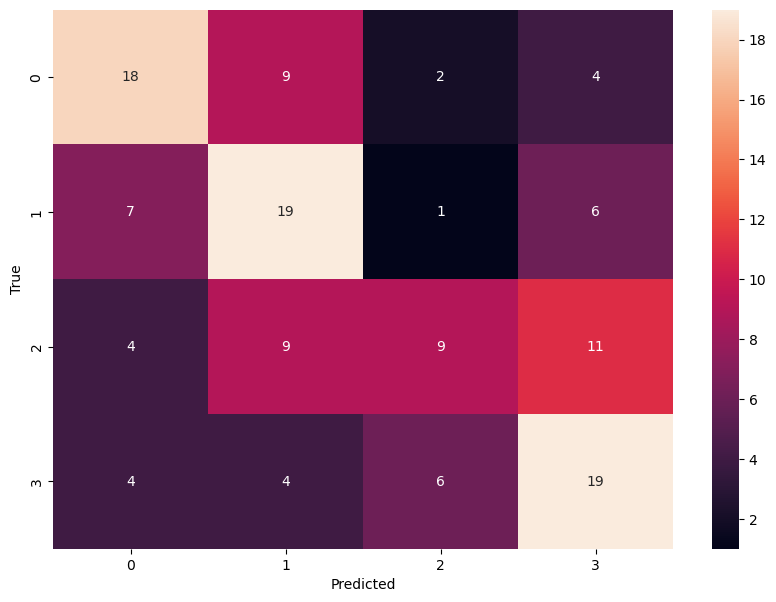

Incorrect Predictions:
Text: I filed a fraud report with the ftc and they still havent took the fraudulent accounts off my report please this is hurting me from taking care of my family and hurting me in my everyday like I need those thing took off my account so I can get a credit card and auto loan for myself its been thirty days and they still havent removed the items, Predicted: 2, Actual: 0
Text: I have paid over {$12000.00} to this company for a service that at first was provided. Since my final payment in XXXX this company has not honored in finishing their agreement to settling 3 accounts. Once I finished my part of the arrangement and I fully paid, suddenly I became the easiest to ignore. I have called, emailed, used the webpage contact us, and my login access page. All attempts from me to contact anyone of authority to finish their side and resolve my 3 accounts have been fully ignored. I have had no success in getting this company to honor their end and finish settlements. In

In [11]:
### Use STSB-BERT model and logistic regression in PyTorch with manual hyperparameter tuning (4 classes)
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

def extract_features(narratives):
    features = []
    domain_terms = ['score','paid','business', 'months', 'consumer', 'financial', 'complaint', 'rights',
                    'violation', 'services', 'theft', 'account', 'agency', 'creditors', 'debt', 'law',
                    'company', 'information', 'money', 'act', 'contract', 'bank', 'reporting', 'legal',
                    'privacy', 'accounts', 'USC', 'card', 'identity', 'payment', 'refund', 'loan', 'fee',
                    'lexington', 'email', 'report', 'credit', 'fair']
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, features, manual_features, tfidf_features, labels):
        self.features = features  # Sentence embeddings
        self.manual_features = torch.tensor(manual_features).float()  # Manual features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()  # TF-IDF features
        self.labels = torch.tensor(labels).long()  # Labels

    def __getitem__(self, idx):
        combined_features = torch.cat((self.features[idx], self.manual_features[idx], self.tfidf_features[idx]), dim=0)
        item = {'features': combined_features, 'labels': self.labels[idx]}
        return item

    def __len__(self):
        return len(self.labels)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

# Load and preprocess the dataset
file_path = 'complaints-official-4-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

# Extract manual features
manual_features = extract_features(df['Consumer complaint narrative'])

# Define the ratios for splitting the dataset
train_ratio = 0.20
validation_ratio = 0.20
test_ratio = 0.60

# Split the dataset and manual features
train_data, temp_data = train_test_split(df, train_size=train_ratio, stratify=df['Label'])
train_manual_features, temp_manual_features = train_test_split(manual_features, train_size=train_ratio, stratify=df['Label'])
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])
val_manual_features, test_manual_features = train_test_split(temp_manual_features, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])

# Initialize TF-IDF Vectorizer and compute TF-IDF features for each set
tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Consumer complaint narrative'])
val_tfidf = tfidf_vectorizer.transform(val_data['Consumer complaint narrative'])
test_tfidf = tfidf_vectorizer.transform(test_data['Consumer complaint narrative'])

# Extract texts and labels for each set
train_texts, train_labels = train_data['Consumer complaint narrative'].tolist(), train_data['Label'].tolist()
val_texts, val_labels = val_data['Consumer complaint narrative'].tolist(), val_data['Label'].tolist()
test_texts, test_labels = test_data['Consumer complaint narrative'].tolist(), test_data['Label'].tolist()

# Initialize the tokenizer and model for 'stsb-bert-base'
tokenizer = BertTokenizer.from_pretrained('sentence-transformers/stsb-bert-base')
bert_model = BertModel.from_pretrained('sentence-transformers/stsb-bert-base')

def encode_texts(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = bert_model(**encoded_input)
    return model_output.pooler_output

# Encode the data
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

# Create datasets
train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
test_dataset = ComplaintsDataset(torch.tensor(test_encodings), test_manual_features, test_tfidf, test_labels)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the logistic regression model with the updated input dimension
input_dim = train_encodings.shape[1] + len(train_manual_features[0]) + 500  # Add dimensions of sentence embeddings, manual features, and TF-IDF features
logistic_regression_model = LogisticRegressionModel(input_dim, num_classes=4)  # 4-class classification

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic_regression_model.parameters(), lr=0.00005)

num_epochs = 500
patience = 10
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    logistic_regression_model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_features = batch['features']
        batch_labels = batch['labels']

        optimizer.zero_grad()

        logits = logistic_regression_model(batch_features)
        loss = criterion(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    logistic_regression_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            val_logits = logistic_regression_model(val_features)
            val_loss = criterion(val_logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

logistic_regression_model.eval()
test_predictions = []
test_references = []
incorrect_pred_texts = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = logistic_regression_model(batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

        for j, (pred, label) in enumerate(zip(predictions, batch_labels.tolist())):
            if pred != label:
                incorrect_pred_texts.append((test_texts[i * test_loader.batch_size + j], pred, label))

accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 4 classes (Logistic Regression): {accuracy}')
print(f'Test F1 Score for 4 classes (Logistic Regression): {f1}')

conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Incorrect Predictions:")
for text, pred, label in incorrect_pred_texts:
    print(f"Text: {text}, Predicted: {pred}, Actual: {label}")

Epoch 1/500 | Train Loss: 1.772070864836375 | Validation Loss: 0.6992683708667755
Epoch 2/500 | Train Loss: 0.7269338369369507 | Validation Loss: 0.6722320020198822
Epoch 3/500 | Train Loss: 0.443619708220164 | Validation Loss: 0.9083008766174316
Epoch 4/500 | Train Loss: 0.628675619761149 | Validation Loss: 0.5581061094999313
Epoch 5/500 | Train Loss: 0.2959614892800649 | Validation Loss: 0.5210423469543457
Epoch 6/500 | Train Loss: 0.3106429340938727 | Validation Loss: 0.3842393010854721
Epoch 7/500 | Train Loss: 0.22813440362612405 | Validation Loss: 0.45666465163230896
Epoch 8/500 | Train Loss: 0.1283652757604917 | Validation Loss: 0.45488134026527405
Epoch 9/500 | Train Loss: 0.08351571609576543 | Validation Loss: 0.43081261217594147
Epoch 10/500 | Train Loss: 0.06678084532419841 | Validation Loss: 0.4471268951892853
Epoch 11/500 | Train Loss: 0.053917343417803444 | Validation Loss: 0.4726438373327255
Epoch 12/500 | Train Loss: 0.03384940202037493 | Validation Loss: 0.490051597356

/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3126584420.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3126584420.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/3126584420.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

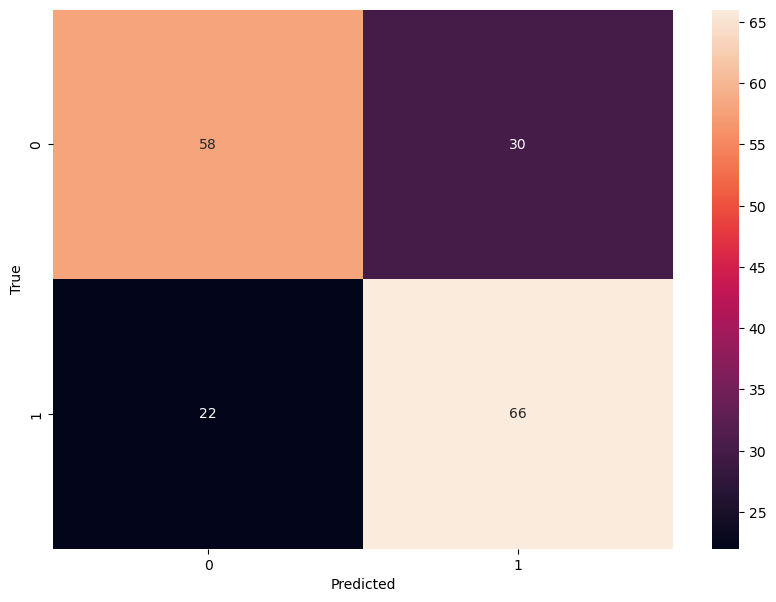

Incorrect Predictions:
Text: I opened an account with the XXXX  XXXX, who uses Global Payments Inc to process deposits. I added my bank account and was denied the ability to make ACH deposits into my account. Upon contacting Global Payments Inc, I was informed that they, illegally, ran a credit check without my permission. Again, there was no request anywhere for my permission to run a credit check. There was nowhere that informed me that one would be run either. I was not seeking credit of any kind, but rather simply adding my own personal bank account for ACH transfers. The Fair Credit Reporting Act ( FCRA ) strictly prohibits pulling a consumer 's credit for an impermissible purpose as Global Payments Inc has done here. Furthermore, Global Payments Inc informed me that my request to add my bank was denied based on said credit check. As I have a credit score of XXXX with all 3 credit agencies, I was very curious as to the reasons I would be denied based on a credit check. I inquired 

In [27]:
### Sentence Transformer with MLPClassifier for 2 classes
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

def extract_features(narratives):
    features = []
    domain_terms = domain_terms = ['credit', 'consumer', 'information', 'account', 'report', 'company',
    'services', 'debt', 'reporting', 'card', 'law', 'refund', 'financial','act', 'loan', 'score', 'service', 'money', 'repair', 'received',
    'complaint', 'action', 'unauthorized', 'paid', 'payments', 'fair',
    'accounts', 'business', 'payment', 'call', 'right', 'section', 'fee',
    'rights', 'provided', 'practices', 'full', 'email', 'USC', 'violation',
    'identity', 'months', 'experian']
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, tfidf_features, labels):
        self.encodings = encodings
        self.features = features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()
        self.labels = labels

    def __getitem__(self, idx):
        combined_features = torch.cat((self.encodings[idx], torch.tensor(self.features[idx]), self.tfidf_features[idx]), dim=0)
        item = {'features': combined_features, 'labels': torch.tensor(self.labels[idx])}
        return item

    def __len__(self):
        return len(self.labels)

class MLPClassifierModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

file_path = 'complaints-official-2-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

manual_features = extract_features(df['Consumer complaint narrative'])

train_ratio = 0.10
validation_ratio = 0.10
test_ratio = 0.80

train_data, temp_data = train_test_split(df, train_size=train_ratio, stratify=df['Label'])
train_manual_features, temp_manual_features = train_test_split(manual_features, train_size=train_ratio, stratify=df['Label'])
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])
val_manual_features, test_manual_features = train_test_split(temp_manual_features, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])

tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Consumer complaint narrative'])
val_tfidf = tfidf_vectorizer.transform(val_data['Consumer complaint narrative'])
test_tfidf = tfidf_vectorizer.transform(test_data['Consumer complaint narrative'])

train_texts, train_labels = train_data['Consumer complaint narrative'].tolist(), train_data['Label'].tolist()
val_texts, val_labels = val_data['Consumer complaint narrative'].tolist(), val_data['Label'].tolist()
test_texts, test_labels = test_data['Consumer complaint narrative'].tolist(), test_data['Label'].tolist()

tokenizer = BertTokenizer.from_pretrained('sentence-transformers/stsb-bert-base')
bert_model = BertModel.from_pretrained('sentence-transformers/stsb-bert-base')

def encode_texts(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = bert_model(**encoded_input)
    return model_output.pooler_output

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

# Create datasets with Sentence Transformer features, manual, and TF-IDF features
train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
test_dataset = ComplaintsDataset(torch.tensor(test_encodings), test_manual_features, test_tfidf, test_labels)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the MLP model with the updated input dimension
input_dim = train_encodings.shape[1] + len(train_manual_features[0]) + 500
mlp_model = MLPClassifierModel(input_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.005, weight_decay=0.001)

num_epochs = 500
patience = 10
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    mlp_model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_features = batch['features']
        batch_labels = batch['labels']

        optimizer.zero_grad()

        logits = mlp_model(batch_features)
        loss = criterion(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation phase
    mlp_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            val_logits = mlp_model(val_features)
            val_loss = criterion(val_logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')
            break

mlp_model.eval()
test_predictions = []
test_references = []
incorrect_pred_texts = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = mlp_model(batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

        for j, (pred, label) in enumerate(zip(predictions, batch_labels.tolist())):
            if pred != label:
                incorrect_pred_texts.append((test_texts[i * test_loader.batch_size + j], pred, label))

accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 2 classes (MLP): {accuracy}')
print(f'Test F1 Score for 2 classes (MLP): {f1}')

conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Incorrect Predictions:")
for text, pred, label in incorrect_pred_texts:
    print(f"Text: {text}, Predicted: {pred}, Actual: {label}")

/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2553222615.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2553222615.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
/var/folders/lt/l92180p93y13zhldz_14cwpc0000gn/T/ipykernel_14577/2553222615.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

Epoch 1/500 | Train Loss: 1.454373339811961 | Validation Loss: 1.365490198135376
Epoch 2/500 | Train Loss: 1.415793001651764 | Validation Loss: 1.357025384902954
Epoch 3/500 | Train Loss: 1.3993815183639526 | Validation Loss: 1.350645939509074
Epoch 4/500 | Train Loss: 1.3699780106544495 | Validation Loss: 1.3452683289845784
Epoch 5/500 | Train Loss: 1.3509314854939778 | Validation Loss: 1.3422218561172485
Epoch 6/500 | Train Loss: 1.3597583572069805 | Validation Loss: 1.3386183977127075
Epoch 7/500 | Train Loss: 1.3406265377998352 | Validation Loss: 1.335833748181661
Epoch 8/500 | Train Loss: 1.3282002806663513 | Validation Loss: 1.3332093954086304
Epoch 9/500 | Train Loss: 1.3028762539227803 | Validation Loss: 1.3320013284683228
Epoch 10/500 | Train Loss: 1.2835168639818828 | Validation Loss: 1.329289197921753
Epoch 11/500 | Train Loss: 1.2774321834246318 | Validation Loss: 1.3274617195129395
Epoch 12/500 | Train Loss: 1.2715132633845012 | Validation Loss: 1.324751615524292
Epoch 13/

Epoch 104/500 | Train Loss: 0.6769771873950958 | Validation Loss: 1.2828133900960286
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 105/500 | Train Loss: 0.6822981238365173 | Validation Loss: 1.282915711402893
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 106/500 | Train Loss: 0.7274103065331777 | Validation Loss: 1.2832705179850261
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 107/500 | Train Loss: 0.6971023182074229 | Validation Loss: 1.2836908896764119
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 108/500 | Train Loss: 0.7009416619936625 | Validation Loss: 1.2854443788528442
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 109/500 | Train Loss: 0.6639622847239176 | Validation Loss: 1.2870489756266277
No improvement in validation loss for 10 consecutive epochs. Stopping training...

Epoch 157/500 | Train Loss: 0.48502882818380993 | Validation Loss: 1.3317099809646606
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 158/500 | Train Loss: 0.4889184931914012 | Validation Loss: 1.3328864574432373
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 159/500 | Train Loss: 0.47988008459409076 | Validation Loss: 1.332265297571818
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 160/500 | Train Loss: 0.4657530412077904 | Validation Loss: 1.3337712685267131
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 161/500 | Train Loss: 0.49187185366948444 | Validation Loss: 1.3346906105677288
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 162/500 | Train Loss: 0.4893282353878021 | Validation Loss: 1.3370554844538372
No improvement in validation loss for 10 consecutive epochs. Stopping training

Epoch 210/500 | Train Loss: 0.3448948860168457 | Validation Loss: 1.3939688603083293
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 211/500 | Train Loss: 0.3498344123363495 | Validation Loss: 1.3951857884724934
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 212/500 | Train Loss: 0.34598299364248913 | Validation Loss: 1.3966497977574666
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 213/500 | Train Loss: 0.32943494121233624 | Validation Loss: 1.3980766534805298
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 214/500 | Train Loss: 0.33253112186988193 | Validation Loss: 1.398889144261678
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 215/500 | Train Loss: 0.34145398437976837 | Validation Loss: 1.3992996613184612
No improvement in validation loss for 10 consecutive epochs. Stopping trainin

Epoch 262/500 | Train Loss: 0.24046719074249268 | Validation Loss: 1.4645217657089233
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 263/500 | Train Loss: 0.23728338132301965 | Validation Loss: 1.4664270877838135
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 264/500 | Train Loss: 0.22472601880629858 | Validation Loss: 1.466571052869161
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 265/500 | Train Loss: 0.22973117480675379 | Validation Loss: 1.4685972929000854
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 266/500 | Train Loss: 0.22903026143709818 | Validation Loss: 1.469856858253479
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 267/500 | Train Loss: 0.2269728034734726 | Validation Loss: 1.4706682364145915
No improvement in validation loss for 10 consecutive epochs. Stopping trainin

Epoch 315/500 | Train Loss: 0.16730778912703195 | Validation Loss: 1.5370266040166218
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 316/500 | Train Loss: 0.16279954463243484 | Validation Loss: 1.5365629593531291
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 317/500 | Train Loss: 0.15944810211658478 | Validation Loss: 1.537354548772176
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 318/500 | Train Loss: 0.1583148861924807 | Validation Loss: 1.538232684135437
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 319/500 | Train Loss: 0.15757751216491064 | Validation Loss: 1.5381195942560832
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 320/500 | Train Loss: 0.15619699160257974 | Validation Loss: 1.5396090745925903
No improvement in validation loss for 10 consecutive epochs. Stopping trainin

Epoch 368/500 | Train Loss: 0.11682880918184917 | Validation Loss: 1.6024003823598225
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 369/500 | Train Loss: 0.11959508309761684 | Validation Loss: 1.6046305894851685
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 370/500 | Train Loss: 0.11462439099947612 | Validation Loss: 1.6047255198160808
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 371/500 | Train Loss: 0.11311535909771919 | Validation Loss: 1.6060354312260945
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 372/500 | Train Loss: 0.11009870345393817 | Validation Loss: 1.6086862881978352
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 373/500 | Train Loss: 0.11150951435168584 | Validation Loss: 1.6108872095743816
No improvement in validation loss for 10 consecutive epochs. Stopping trai

Epoch 421/500 | Train Loss: 0.0863868532081445 | Validation Loss: 1.6740695635477703
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 422/500 | Train Loss: 0.08283197072645028 | Validation Loss: 1.675936261812846
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 423/500 | Train Loss: 0.08286049962043762 | Validation Loss: 1.6768772999445598
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 424/500 | Train Loss: 0.08272918934623401 | Validation Loss: 1.6790923277537029
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 425/500 | Train Loss: 0.08044764026999474 | Validation Loss: 1.6817553440729778
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 426/500 | Train Loss: 0.08031963929533958 | Validation Loss: 1.6826603809992473
No improvement in validation loss for 10 consecutive epochs. Stopping traini

Epoch 473/500 | Train Loss: 0.061970614517728485 | Validation Loss: 1.7375877698262532
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 474/500 | Train Loss: 0.06018357972304026 | Validation Loss: 1.7399557034174602
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 475/500 | Train Loss: 0.05813186056911945 | Validation Loss: 1.7409741481145222
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 476/500 | Train Loss: 0.060298273960749306 | Validation Loss: 1.7428311904271443
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 477/500 | Train Loss: 0.05744303638736407 | Validation Loss: 1.7426117261250813
No improvement in validation loss for 10 consecutive epochs. Stopping training...
Epoch 478/500 | Train Loss: 0.06066218142708143 | Validation Loss: 1.7427306572596233
No improvement in validation loss for 10 consecutive epochs. Stopping tr

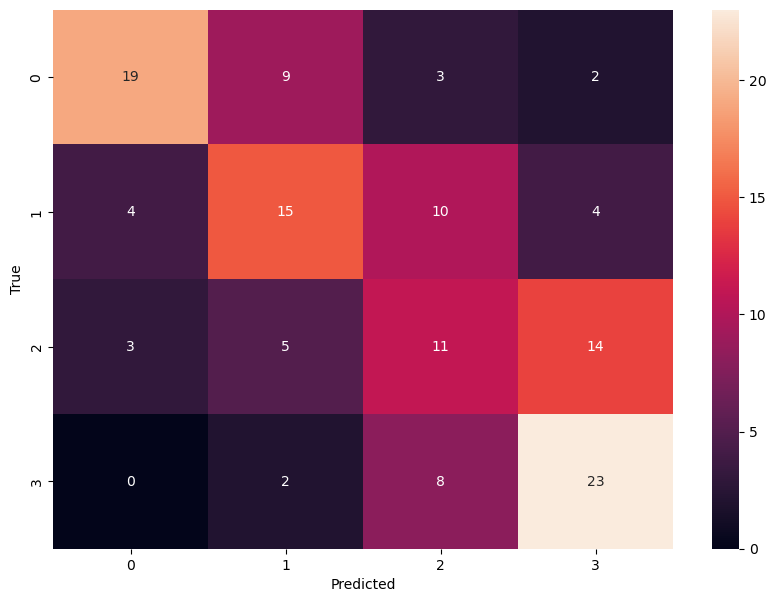

Incorrect Predictions:
Text: In XXXX of this year, I was approached via phone by a representative from Lexington Law Firm offering financial advice and assistance in resolving consumer debt. I initially agreed to a five-day free trial of their services. However, after conducting an internet search and discovering numerous negative reviews about the firm, I immediately contacted the representative to cancel the subscription within the trial period.

Despite my clear instructions to cancel the subscription, I was shocked to find an unauthorized charge of $160.00 drafted from my checking account at [Bank Name] on [Date, Year]. I contacted Lexington Law Firm and, after an arduous conversation with a paralegal (who, I later found out, is not registered in the state of Utah), I was eventually promised a refund by a supervisor. This refund, confirmed via email, was supposed to be processed by XXXX of this year, but to date, it has not been received.

Further attempts to resolve this issue led

In [17]:
### Sentence Transformer with MLPClassifier for 4 classes
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

def extract_features(narratives):
    features = []
    domain_terms = ['score','paid','business', 'months', 'consumer', 'financial', 'complaint', 'rights',
                    'violation', 'services', 'theft', 'account', 'agency', 'creditors', 'debt', 'law',
                    'company', 'information', 'money', 'act', 'contract', 'bank', 'reporting', 'legal',
                    'privacy', 'accounts', 'usc', 'card', 'identity', 'payment', 'refund', 'loan', 'fee',
                    'lexington', 'email', 'report', 'credit', 'fair']
    for narrative in narratives:
        sentences = nltk.sent_tokenize(narrative)
        avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences) if sentences else 0
        domain_term_count = sum(narrative.lower().count(term) for term in domain_terms)
        features.append([avg_sentence_length, domain_term_count])
    return features

class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, features, manual_features, tfidf_features, labels):
        self.features = features  # Sentence embeddings
        self.manual_features = torch.tensor(manual_features).float()  # Manual features
        self.tfidf_features = torch.tensor(tfidf_features.todense()).float()  # TF-IDF features
        self.labels = torch.tensor(labels).long()  # Labels

    def __getitem__(self, idx):
        combined_features = torch.cat((self.features[idx], self.manual_features[idx], self.tfidf_features[idx]), dim=0)
        item = {'features': combined_features, 'labels': self.labels[idx]}
        return item

    def __len__(self):
        return len(self.labels)

class MLPClassifierModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.relu = nn.ReLU()                # ReLU activation function
        self.fc2 = nn.Linear(128, num_classes)  # Second fully connected layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

file_path = 'complaints-official-4-classes.xlsx'
df = pd.read_excel(file_path)
df = df[['Consumer complaint narrative', 'Label']]
df.dropna(inplace=True)

manual_features = extract_features(df['Consumer complaint narrative'])

train_ratio = 0.20
validation_ratio = 0.20
test_ratio = 0.60

train_data, temp_data = train_test_split(df, train_size=train_ratio, stratify=df['Label'])
train_manual_features, temp_manual_features = train_test_split(manual_features, train_size=train_ratio, stratify=df['Label'])
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])
val_manual_features, test_manual_features = train_test_split(temp_manual_features, test_size=test_ratio/(test_ratio + validation_ratio), stratify=temp_data['Label'])

tfidf_vectorizer = TfidfVectorizer(max_features=500)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Consumer complaint narrative'])
val_tfidf = tfidf_vectorizer.transform(val_data['Consumer complaint narrative'])
test_tfidf = tfidf_vectorizer.transform(test_data['Consumer complaint narrative'])

train_texts, train_labels = train_data['Consumer complaint narrative'].tolist(), train_data['Label'].tolist()
val_texts, val_labels = val_data['Consumer complaint narrative'].tolist(), val_data['Label'].tolist()
test_texts, test_labels = test_data['Consumer complaint narrative'].tolist(), test_data['Label'].tolist()

tokenizer = BertTokenizer.from_pretrained('sentence-transformers/stsb-bert-base')
bert_model = BertModel.from_pretrained('sentence-transformers/stsb-bert-base')

def encode_texts(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = bert_model(**encoded_input)
    return model_output.pooler_output

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

train_dataset = ComplaintsDataset(torch.tensor(train_encodings), train_manual_features, train_tfidf, train_labels)
val_dataset = ComplaintsDataset(torch.tensor(val_encodings), val_manual_features, val_tfidf, val_labels)
test_dataset = ComplaintsDataset(torch.tensor(test_encodings), test_manual_features, test_tfidf, test_labels)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the MLP model with the updated input dimension
input_dim = train_encodings.shape[1] + len(train_manual_features[0]) + 500
mlp_model = MLPClassifierModel(input_dim, num_classes=4)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.00005)

num_epochs = 500
patience = 10
best_val_loss = float('inf')
no_improvement = 0

for epoch in range(num_epochs):
    mlp_model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch_features = batch['features']
        batch_labels = batch['labels']

        optimizer.zero_grad()
        logits = mlp_model(batch_features)
        loss = criterion(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    mlp_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_features = val_batch['features']
            val_labels = val_batch['labels']

            val_logits = mlp_model(val_features)
            val_loss = criterion(val_logits, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {total_train_loss / len(train_loader)} | Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'No improvement in validation loss for {patience} consecutive epochs. Stopping training...')

# Evaluation for 4-class Classification using MLP Classifier
mlp_model.eval()
test_predictions = []
test_references = []
incorrect_pred_texts = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch_features = batch['features']
        batch_labels = batch['labels']

        logits = mlp_model(batch_features)
        predictions = torch.argmax(logits, dim=-1).tolist()
        test_predictions.extend(predictions)
        test_references.extend(batch_labels.tolist())

        for j, (pred, label) in enumerate(zip(predictions, batch_labels.tolist())):
            if pred != label:
                incorrect_pred_texts.append((test_texts[i * test_loader.batch_size + j], pred, label))

accuracy = accuracy_score(test_references, test_predictions)
f1 = f1_score(test_references, test_predictions, average='weighted')

print(f'Test Accuracy for 4 classes (MLP): {accuracy}')
print(f'Test F1 Score for 4 classes (MLP): {f1}')

conf_matrix = sk_confusion_matrix(test_references, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Incorrect Predictions:")
for text, pred, label in incorrect_pred_texts:
    print(f"Text: {text}, Predicted: {pred}, Actual: {label}")